# Workshop: Optimization
**Part III**

In this coding exercise, we try to program up

* PALM Algorithm for Robust Logistic Regression
* SR3 Algorithm for Fast Sparse Logistic Regression

algorithms use logistic regression as an example.

---

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

In [2]:
# load data
train_images = np.load('../data/train_images.npy')
train_labels = np.load('../data/train_labels.npy')
test_images = np.load('../data/test_images.npy')
test_labels = np.load('../data/test_labels.npy')

num_train_images = train_labels.size
num_test_images = test_labels.size
image_size = 28*28

print('number of training images: %i' % num_train_images)
print('number of testing images: %i' % num_test_images)

number of training images: 1000
number of testing images: 200


## PALM Algorithm

[PALM](https://pdfs.semanticscholar.org/c2a3/59e9408191c9b26dfb7d4fc5389da19e208d.pdf)
algorithm is one of the most flexible method that can deal with structural non-smooth non-convex objective.
And [Trimming](https://arxiv.org/abs/1610.01101) is a very powerful robustification of any summable objective.
In this part, we will see how can we apply PALM to solve trimmed logistic regression.

Consider optimization problem,
$$
\min_{x, w\in\triangle_k}~~f(x,w):=\sum_{i=1}^m w_i h_i(x) + g(x)
$$
where,
$$
h_i(x) = \ln(1 + \exp(\langle a_i, x \rangle)) - y_i \langle a_i, x \rangle, \quad
g(x) = \lambda \|x\|_1,
$$
and $\triangle_k$ is the $k$-capped simplex,
$$
\triangle_k = \left\{w : w\in [0,1]^m, \sum_{i=1}^m w_i = k\right\}.
$$

PALM algorithm for this objective can be summarized as follows,

* input: $x_0$, $w_0$, $\tau$
* set $k = 0$
* while $\beta\|x_k - x_{k-1}\| \ge $ tolerance
\begin{align*}
x_{k+1} &\leftarrow \text{prox}_{g/\beta}(x_k - \tfrac{1}{\beta} \nabla_x f(x_k, w_k))\\
w_{k+1} &\leftarrow \text{proj}_{\triangle_h}(w_k - \tau \nabla_w f(x_{k+1}, w_k))\\
k &\leftarrow k + 1
\end{align*}
end
* output: $x_k$

In [3]:
# define functions
A = train_images
y = train_labels

lam = 1.0

beta_h = 0.25*np.linalg.norm(A, 2)**2

def func_h(x):
    z = A.dot(x)
    return np.log(1.0 + np.exp(z)) - y*z

def grad_h(x, w):
    z = A.dot(x)
    return (A.T*w).dot(np.exp(z)/(1.0 + np.exp(z)) - y)

def func_g(x):
    return lam*np.sum(np.abs(x))

def prox_g(x, t):
    t = lam*t
    y = np.zeros(x.size, dtype=x.dtype)

    ind = np.where(np.abs(x) > t)
    x_o = x[ind]

    y[ind] = np.sign(x_o)*(np.abs(x_o) - t)

    return y

In [4]:
# proximal gradient descent
def optimizeWithTrimmingPGD(x0, func_h, func_g, grad_h, prox_g, beta_h, num_inliers, N,
                            weight_step_size=1.0, tol=1e-6, max_iter=1000):
    """
    Optimize with Trimming Proximal Gradient Descent Method
        min_{x, w} <w, h(x)> + g(x)
    where h is beta smooth and g is proxiable.
    
    input
    -----
    x0 : array_like
        Starting point for the solver
    func_h : function
        Input x and return the function value of h
    func_g : function
        Input x and return the function value of g
    grad_h : function
        Input x and return the gradient of h
    prox_g : function
        Input x and a constant float number and return the prox solution
    beta_h : float
        beta smoothness constant for h
    num_inliers : int
        number of inliers
    N : int
        total number of data points
    weight_step_size : float, optional
        step size for the trimming weight
    tol : float, optional
        Gradient tolerance for terminating the solver.
    max_iter : int, optional
        Maximum number of iteration for terminating the solver.
        
    output
    ------
    x : array_like
        Final solution
    w : array_like
        weights of the data points
    obj_his : array_like
        Objective function value convergence history
    err_his : array_like
        Norm of gradient convergence history
    exit_flag : int
        0, norm of gradient below `tol`
        1, exceed maximum number of iteration
        2, others
    """
    # initial information
    x = x0.copy()
    w = np.repeat(num_inliers/N, N)
    g = grad_h(x, w)
    #
    step_size = 1.0/beta_h
    # not recording the initial point since we do not have measure of the optimality
    obj_his = np.zeros(max_iter)
    err_his = np.zeros(max_iter)
    
    # start iteration
    iter_count = 0
    err = tol + 1.0
    while err >= tol:
        # proximal gradient descent step
        x_new = prox_g(x - step_size*g, step_size)
        w_new = projCappedSimplex(w - weight_step_size*func_h(x_new), num_inliers)
        
        # update information
        obj = w_new.dot(func_h(x_new)) + func_g(x_new)
        err = np.linalg.norm(x - x_new)/step_size
        #
        np.copyto(x, x_new)
        np.copyto(w, w_new)
        g = grad_h(x, w)
        #
        obj_his[iter_count] = obj
        err_his[iter_count] = err
        #
        # check if exceed maximum number of iteration
        iter_count += 1
        if iter_count >= max_iter:
            print('Proximal gradient descent with trimming reach maximum of iteration')
            return x, w, obj_his[:iter_count], err_his[:iter_count], 1
    #
    return x, w, obj_his[:iter_count], err_his[:iter_count], 0

def projCappedSimplex(w, w_sum):
    a = np.min(w) - 1.0
    b = np.max(w) - 0.0

    def f(x):
        return np.sum(np.maximum(np.minimum(w - x, 1.0), 0.0)) - w_sum

    x = bisect(f, a, b)

    return np.maximum(np.minimum(w - x, 1.0), 0.0)

In [5]:
# apply the algorithm
x0 = np.zeros(image_size)

x, w, obj_his, err_his, exit_flag = optimizeWithTrimmingPGD(x0, func_h, func_g, grad_h, prox_g, beta_h,
                                                            int(0.95*num_train_images), num_train_images)

Proximal gradient descent with trimming reach maximum of iteration


Text(0.5, 0.98, 'Proximal Gradient Descent on Logistic Regression With Trimming')

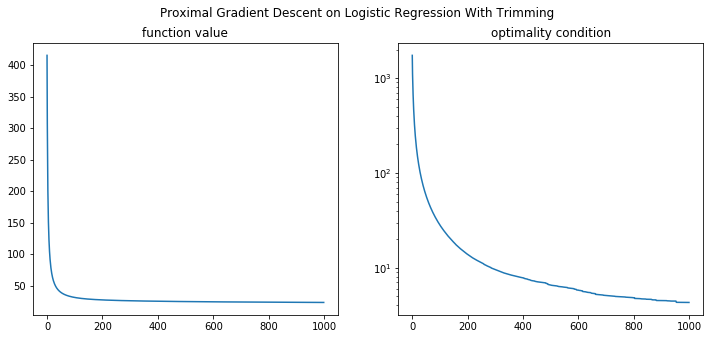

In [6]:
# plot convergence result
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(obj_his)
ax[0].set_title('function value')
ax[1].semilogy(err_his)
ax[1].set_title('optimality condition')
fig.suptitle('Proximal Gradient Descent on Logistic Regression With Trimming')

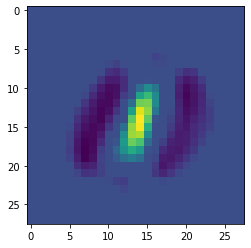

In [7]:
# plot the identifier
plt.imshow(x.reshape(28, 28))

In [8]:
# test result
A_test = test_images
y_test = test_labels

z_test = A_test.dot(x)

rate = np.sum(((z_test < 0.0) & (y_test == 0.0)) | ((z_test > 0.0) & (y_test == 1.0)))/num_test_images

print('correctly classify %0.2f of the testing data.' % rate)

correctly classify 1.00 of the testing data.
